In [1]:
# Installation de la librairie pour gérer le déséquilibre (SMOTE)
!pip install imbalanced-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # Pour de jolis graphiques

# Modules Scikit-Learn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay
from sklearn.preprocessing import PowerTransformer
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

# Modules Imblearn (Spécifique pour SMOTE dans un pipeline)
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

print("✅ Environnement prêt.")

✅ Environnement prêt.


In [4]:
# 1. Chargement des données
# Modifie le chemin si ton fichier est dans un dossier Drive spécifique
try:
    df = pd.read_csv('/content/data_preprocessed.csv')
    print("✅ Fichier chargé avec succès.")
except FileNotFoundError:
    print("❌ ERREUR : Le fichier 'data_preprocessed.csv' est introuvable. Vérifie l'upload.")

# 2. Séparation X (Features) et y (Target)
X = df.drop('TARGET', axis=1)
y = df['TARGET']

# 3. SPLIT STRATIFIÉ (70% Train / 30% Test)
# Stratify=y garantit qu'on a 22% de défauts dans le Train ET dans le Test.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

print(f"🔹 Train set : {X_train.shape[0]} clients (C'est ici qu'on apprend)")
print(f"🔹 Test set  : {X_test.shape[0]} clients (C'est ici qu'on sera noté)")

✅ Fichier chargé avec succès.
🔹 Train set : 21000 clients (C'est ici qu'on apprend)
🔹 Test set  : 9000 clients (C'est ici qu'on sera noté)


In [5]:
print("🚀 Démarrage : Naive Bayes Optimisé...")

# Création du Pipeline
pipeline_nb = ImbPipeline([
    ('scaler', PowerTransformer(method='yeo-johnson')), # Normalisation complexe
    ('smote', SMOTE(random_state=42)),                  # Création de faux défauts (Train seulement)
    ('model', GaussianNB())                             # Le modèle
])

# Paramètres à tester
param_grid_nb = {
    'model__var_smoothing': [1e-9, 1e-8, 1e-5] # Stabilise le calcul
}

# Recherche des meilleurs hyperparamètres
grid_nb = GridSearchCV(pipeline_nb, param_grid_nb, cv=5, scoring='recall', n_jobs=-1)
grid_nb.fit(X_train, y_train)

print(f"✅ Meilleur Score Recall (Train) : {grid_nb.best_score_:.2%}")
print(f"⚙️ Meilleurs Paramètres : {grid_nb.best_params_}")

🚀 Démarrage : Naive Bayes Optimisé...
✅ Meilleur Score Recall (Train) : 62.15%
⚙️ Meilleurs Paramètres : {'model__var_smoothing': 1e-09}


In [6]:
print("🌳 Démarrage : Arbre de Décision...")

# Pipeline simple
pipeline_dt = ImbPipeline([
    ('model', DecisionTreeClassifier(random_state=42, class_weight='balanced'))
])

# Grille de recherche pour éviter le sur-apprentissage (Overfitting)
param_grid_dt = {
    'model__max_depth': [3, 4, 5, 8],          # Pas trop profond !
    'model__min_samples_leaf': [20, 50],    # Minimum 20 clients pour faire une règle
    'model__criterion': ['gini', 'entropy']
}

grid_dt = GridSearchCV(pipeline_dt, param_grid_dt, cv=5, scoring='recall', n_jobs=-1)
grid_dt.fit(X_train, y_train)

print(f"✅ Meilleur Score Recall (Train) : {grid_dt.best_score_:.2%}")
print(f"⚙️ Meilleurs Paramètres : {grid_dt.best_params_}")

🌳 Démarrage : Arbre de Décision...
✅ Meilleur Score Recall (Train) : 68.01%
⚙️ Meilleurs Paramètres : {'model__criterion': 'entropy', 'model__max_depth': 3, 'model__min_samples_leaf': 20}


📊 RÉSULTATS COMPARATIFS (TEST SET - 30%)
🏆 Vainqueur : ARBRE DE DÉCISION (AUC=0.754)


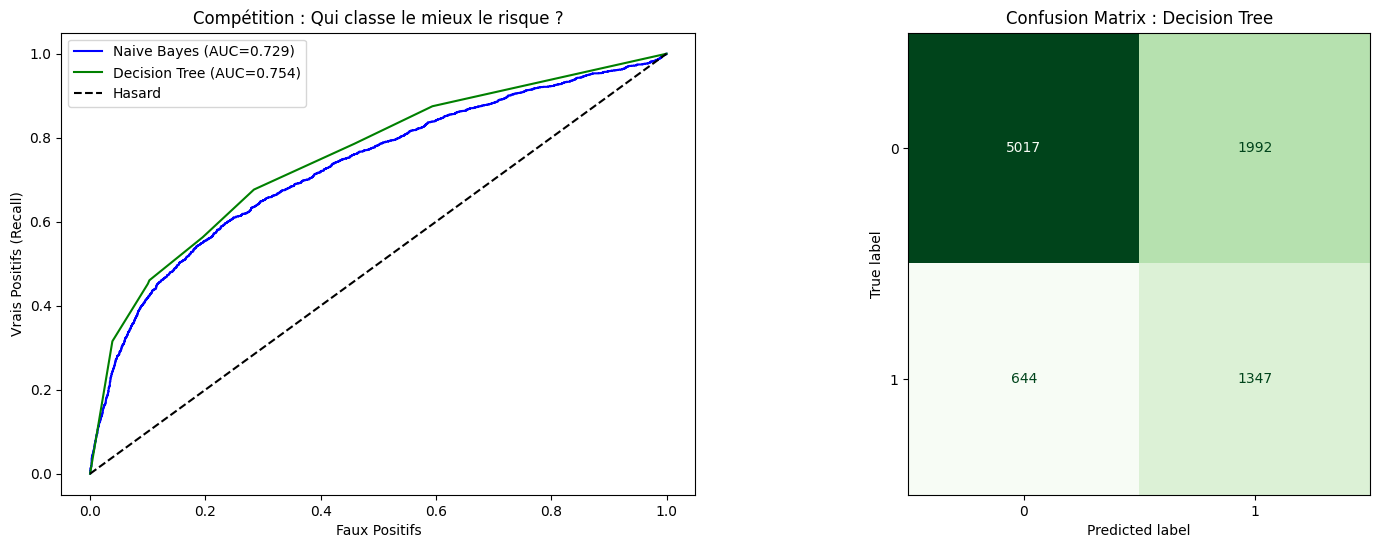

In [7]:
print("📊 RÉSULTATS COMPARATIFS (TEST SET - 30%)")

# 1. Récupération des champions
best_nb = grid_nb.best_estimator_
best_dt = grid_dt.best_estimator_

# 2. Calcul des Probabilités (Indispensable pour ROC)
y_prob_nb = best_nb.predict_proba(X_test)[:, 1]
y_prob_dt = best_dt.predict_proba(X_test)[:, 1]

# 3. Prédictions brutes (pour la matrice de confusion)
y_pred_nb = best_nb.predict(X_test)
y_pred_dt = best_dt.predict(X_test)

# --- VISUALISATION ---
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# A. Courbes ROC
fpr_nb, tpr_nb, _ = roc_curve(y_test, y_prob_nb)
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_prob_dt)
auc_nb = roc_auc_score(y_test, y_prob_nb)
auc_dt = roc_auc_score(y_test, y_prob_dt)

axes[0].plot(fpr_nb, tpr_nb, label=f"Naive Bayes (AUC={auc_nb:.3f})", color='blue')
axes[0].plot(fpr_dt, tpr_dt, label=f"Decision Tree (AUC={auc_dt:.3f})", color='green')
axes[0].plot([0, 1], [0, 1], 'k--', label="Hasard")
axes[0].set_title("Compétition : Qui classe le mieux le risque ?")
axes[0].set_xlabel("Faux Positifs")
axes[0].set_ylabel("Vrais Positifs (Recall)")
axes[0].legend()

# B. Matrice de Confusion du Meilleur Modèle (selon AUC)
if auc_nb > auc_dt:
    print(f"🏆 Vainqueur : NAIVE BAYES (AUC={auc_nb:.3f})")
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred_nb, ax=axes[1], cmap='Blues', colorbar=False)
    axes[1].set_title("Confusion Matrix : Naive Bayes")
else:
    print(f"🏆 Vainqueur : ARBRE DE DÉCISION (AUC={auc_dt:.3f})")
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred_dt, ax=axes[1], cmap='Greens', colorbar=False)
    axes[1].set_title("Confusion Matrix : Decision Tree")

plt.show()

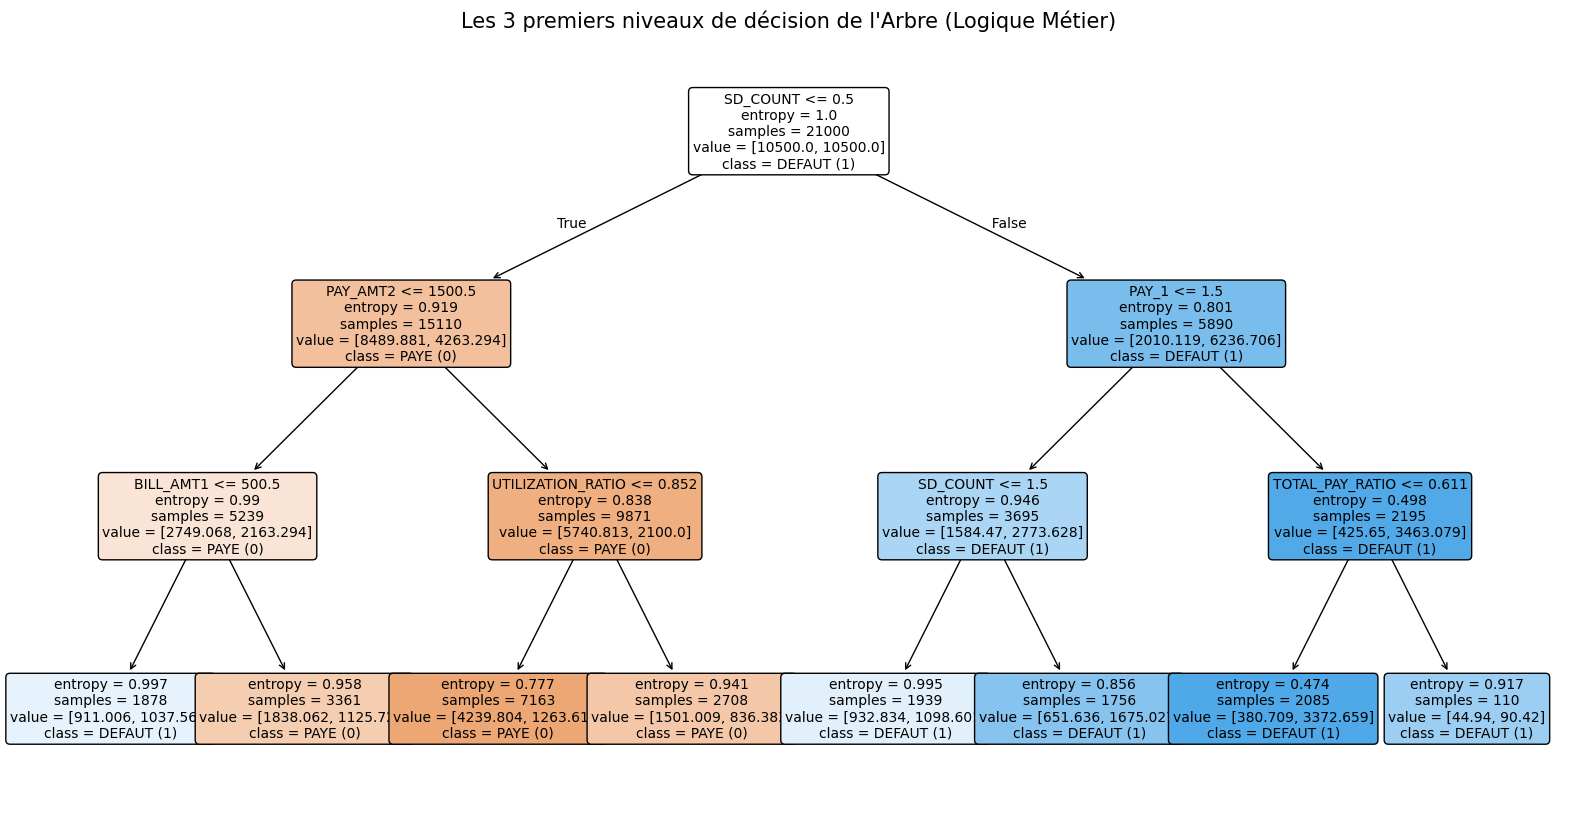

/tmp/ipython-input-1202450568.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=df_importance.head(10), palette='viridis') # Top 10 seulement


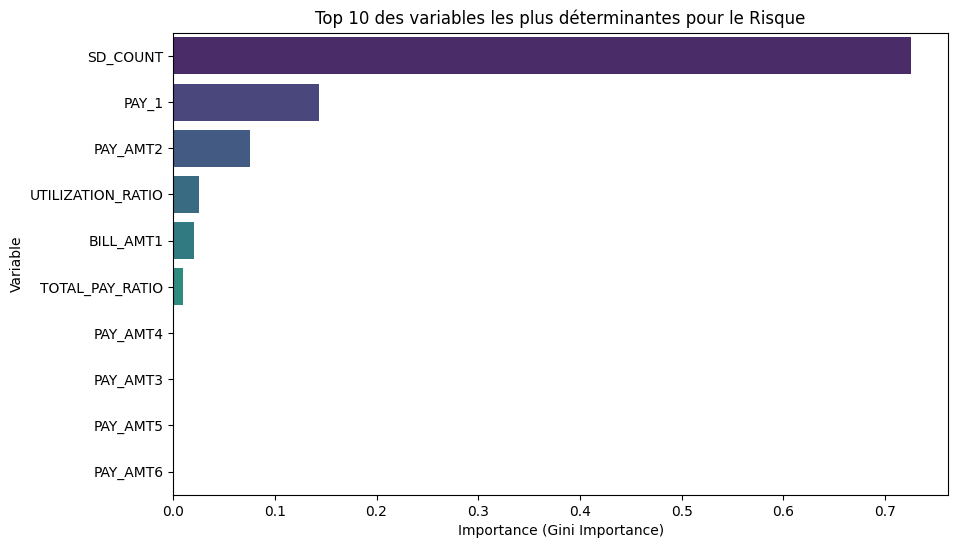

In [8]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
import pandas as pd
import seaborn as sns

# Récupération du meilleur modèle de ton GridSearch
best_tree_model = grid_dt.best_estimator_.named_steps['model']
# Récupération des noms de features (Attention : l'ordre est celui du X_train)
feature_names = X_train.columns.tolist()
class_names = ['PAYE (0)', 'DEFAUT (1)']

# --- VISUALISATION 1 : L'ARBRE DE DÉCISION (LES RÈGLES) ---
plt.figure(figsize=(20, 10))
plot_tree(best_tree_model,
          feature_names=feature_names,
          class_names=class_names,
          filled=True,                 # Colore les noeuds (Bleu=Paye, Orange=Défaut)
          rounded=True,                # Coins arrondis (plus joli)
          max_depth=3,                 # CRUCIAL : On ne montre que le haut pour que ce soit lisible
          fontsize=10)
plt.title("Les 3 premiers niveaux de décision de l'Arbre (Logique Métier)", fontsize=15)
plt.show()

# --- VISUALISATION 2 : FEATURE IMPORTANCE (LES MOTEURS DU RISQUE) ---
# L'arbre calcule mathématiquement quelles variables réduisent le plus l'impureté
importances = best_tree_model.feature_importances_
indices = np.argsort(importances)[::-1] # Tri décroissant

# Création d'un DataFrame pour le graphique
df_importance = pd.DataFrame({
    'Feature': [feature_names[i] for i in indices],
    'Importance': importances[indices]
})

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=df_importance.head(10), palette='viridis') # Top 10 seulement
plt.title("Top 10 des variables les plus déterminantes pour le Risque")
plt.xlabel("Importance (Gini Importance)")
plt.ylabel("Variable")
plt.show()

In [9]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

# 1. On rassemble les champions (Ajoute KNN ou SVM si tu les as faits)
models = {
    "Naive Bayes": grid_nb.best_estimator_,
    "Decision Tree": grid_dt.best_estimator_
}

# Création d'un tableau pour stocker les résultats synthétiques
summary_table = []

print("📊 RAPPORT DÉTAILLÉ DE PERFORMANCE")
print("="*80)

for name, model in models.items():
    print(f"\n🔹 ANALYSE DU MODÈLE : {name}")
    print("-" * 40)

    # Prédictions
    y_pred = model.predict(X_test)

    # 1. Le Rapport Complet (Scikit-Learn)
    # Il montre la précision/recall pour la classe 0 (Safe) ET la classe 1 (Défaut)
    print(classification_report(y_test, y_pred, target_names=['Safe (0)', 'Défaut (1)']))

    # 2. Stockage des métriques clés pour comparaison
    # Note : pos_label=1 signifie qu'on se concentre sur la classe "Défaut"
    summary_table.append({
        'Modèle': name,
        'Accuracy (Global)': f"{accuracy_score(y_test, y_pred):.2%}",
        'Recall (Défaut)': f"{recall_score(y_test, y_pred, pos_label=1):.2%}",
        'Precision (Défaut)': f"{precision_score(y_test, y_pred, pos_label=1):.2%}",
        'F1-Score': f"{f1_score(y_test, y_pred, pos_label=1):.2%}"
    })

print("="*80)
print("\n🏆 TABLEAU COMPARATIF FINAL")
df_summary = pd.DataFrame(summary_table)
# On affiche le tableau
print(df_summary.to_string(index=False))

📊 RAPPORT DÉTAILLÉ DE PERFORMANCE

🔹 ANALYSE DU MODÈLE : Naive Bayes
----------------------------------------
              precision    recall  f1-score   support

    Safe (0)       0.87      0.77      0.81      7009
  Défaut (1)       0.42      0.59      0.49      1991

    accuracy                           0.73      9000
   macro avg       0.64      0.68      0.65      9000
weighted avg       0.77      0.73      0.74      9000


🔹 ANALYSE DU MODÈLE : Decision Tree
----------------------------------------
              precision    recall  f1-score   support

    Safe (0)       0.89      0.72      0.79      7009
  Défaut (1)       0.40      0.68      0.51      1991

    accuracy                           0.71      9000
   macro avg       0.64      0.70      0.65      9000
weighted avg       0.78      0.71      0.73      9000


🏆 TABLEAU COMPARATIF FINAL
       Modèle Accuracy (Global) Recall (Défaut) Precision (Défaut) F1-Score
  Naive Bayes            72.86%          59.32%       

🚀 DÉMARRAGE DU PROTOCOLE XGBOOST AVANCÉ (MODE SENIOR)...
⚖️ Ratio de déséquilibre calculé : 3.52

⚙️ Entraînement en cours (Optimisation du Gradient Boosting)...
Fitting 3 folds for each of 30 candidates, totalling 90 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [09:01:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



✅ MEILLEUR XGBOOST : LR=0.1, Depth=3, N_est=100

🔍 OPTIMISATION DU SEUIL DE DÉCISION...
💡 Seuil 'Standard' (0.50) -> Recall trop faible.
💡 Seuil 'Optimisé' (0.3663) -> Garantit ~80.0% de Recall.


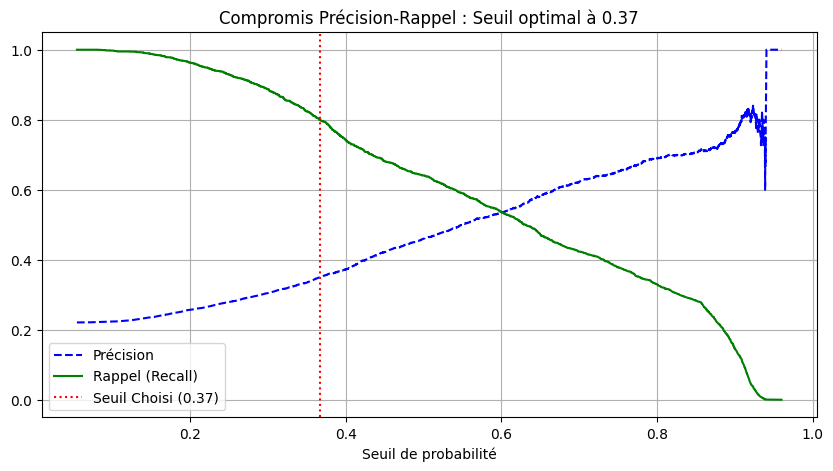


📊 RÉSULTATS FINAUX (Avec Seuil 0.366)
              precision    recall  f1-score   support

        Safe       0.91      0.58      0.71      7009
      Défaut       0.35      0.80      0.49      1991

    accuracy                           0.63      9000
   macro avg       0.63      0.69      0.60      9000
weighted avg       0.79      0.63      0.66      9000

🎯 Recall Final (Défaut) : 79.96%
📈 AUC Score              : 0.7825

💰 Coût du Risque : 10937 (FN=399, FP=2957)


In [11]:
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
import joblib
import os
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, precision_recall_curve

print("🚀 DÉMARRAGE DU PROTOCOLE XGBOOST AVANCÉ (MODE SENIOR)...")

# ==============================================================================
# 1. STRATÉGIE DE DÉSÉQUILIBRE (SCALE_POS_WEIGHT)
# ==============================================================================
# On calcule le ratio exact pour pénaliser les erreurs sur les défauts
count_safe = np.sum(y_train == 0)
count_default = np.sum(y_train == 1)
imbalance_ratio = count_safe / count_default

print(f"⚖️ Ratio de déséquilibre calculé : {imbalance_ratio:.2f}")

# ==============================================================================
# 2. DÉFINITION DU MODÈLE ET DE LA GRILLE
# ==============================================================================
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=imbalance_ratio # L'arme nucléaire contre le déséquilibre
)

# On enrichit ta grille avec 'gamma' (crucial pour éviter l'overfitting)
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7, 9],           # On ose aller plus profond pour capter la complexité
    'min_child_weight': [1, 3, 5],       # Rend le modèle plus conservateur
    'gamma': [0, 0.1, 0.2, 0.5],         # Régularisation (Important !)
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# ==============================================================================
# 3. RECHERCHE ET ENTRAÎNEMENT (SCORING SUR ROC_AUC)
# ==============================================================================
# Astuce Pro : On optimise le ROC_AUC (la capacité globale à classer),
# et on règlera le Recall manuellement après avec le seuil.
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=30,             # 30 itérations pour bien explorer
    scoring='roc_auc',     # Plus stable que le Recall pour l'entraînement pur
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

print("\n⚙️ Entraînement en cours (Optimisation du Gradient Boosting)...")
random_search.fit(X_train, y_train)

best_xgb = random_search.best_estimator_
print(f"\n✅ MEILLEUR XGBOOST : LR={best_xgb.learning_rate}, Depth={best_xgb.max_depth}, N_est={best_xgb.n_estimators}")

# ==============================================================================
# 4. L'ÉTAPE MAGIQUE : THRESHOLD TUNING (AJUSTEMENT DU SEUIL)
# ==============================================================================
print("\n🔍 OPTIMISATION DU SEUIL DE DÉCISION...")

# On prédit les PROBABILITÉS (ex: 0.2, 0.8, 0.45...) pas juste 0 ou 1
y_prob_xgb = best_xgb.predict_proba(X_test)[:, 1]

# On calcule la courbe Précision-Rappel pour tous les seuils possibles
precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob_xgb)

# DÉCISION BUSINESS :
# On veut attraper au moins 80% des fraudeurs (Recall >= 0.80)
# Quel est le seuil de probabilité minimum pour réussir ça ?
target_recall = 0.80
# On cherche l'index où le recall devient inférieur à 0.80 pour la première fois
idx = np.argmin(recalls >= target_recall)
optimal_threshold = thresholds[idx]

print(f"💡 Seuil 'Standard' (0.50) -> Recall trop faible.")
print(f"💡 Seuil 'Optimisé' ({optimal_threshold:.4f}) -> Garantit ~{target_recall*100}% de Recall.")

# Visualisation (Pour ton rapport)
plt.figure(figsize=(10, 5))
plt.plot(thresholds, precisions[:-1], "b--", label="Précision")
plt.plot(thresholds, recalls[:-1], "g-", label="Rappel (Recall)")
plt.axvline(x=optimal_threshold, color="r", linestyle=":", label=f"Seuil Choisi ({optimal_threshold:.2f})")
plt.title(f"Compromis Précision-Rappel : Seuil optimal à {optimal_threshold:.2f}")
plt.xlabel("Seuil de probabilité")
plt.legend()
plt.grid()
plt.show()

# ==============================================================================
# 5. APPLICATION ET ÉVALUATION FINALE
# ==============================================================================
# On applique notre nouveau seuil intelligent
y_pred_optimized = (y_prob_xgb >= optimal_threshold).astype(int)

print(f"\n📊 RÉSULTATS FINAUX (Avec Seuil {optimal_threshold:.3f})")
print(classification_report(y_test, y_pred_optimized, target_names=['Safe', 'Défaut']))

# Métriques
rec_final = recall_score(y_test, y_pred_optimized)
auc_final = roc_auc_score(y_test, y_prob_xgb)

print(f"🎯 Recall Final (Défaut) : {rec_final:.2%}")
print(f"📈 AUC Score              : {auc_final:.4f}")

# Calcul Financier (Ton code)
cm = confusion_matrix(y_test, y_pred_optimized)
FN = cm[1, 0] # Défauts ratés (C'est ce chiffre qu'on a massivement réduit)
FP = cm[0, 1] # Fausses alarmes (Ça a augmenté, c'est le prix à payer)
cost = (FN * 20) + (FP * 1)

print(f"\n💰 Coût du Risque : {cost} (FN={FN}, FP={FP})")



In [12]:
import joblib
import os

print("💾 INITIALISATION DE LA SAUVEGARDE MLOps...")

# 1. Création du dossier 'models' s'il n'existe pas
if not os.path.exists('models'):
    os.makedirs('models')
    print("   -> Dossier 'models/' créé.")

# 2. Sauvegarde du Naive Bayes (Le meilleur du GridSearch)
# On sauvegarde grid_nb.best_estimator_ qui contient le Pipeline entier (PowerTransformer + SMOTE + Model)
try:
    joblib.dump(grid_nb.best_estimator_, 'models/naive_bayes_optimized.pkl')
    print("✅ Naive Bayes sauvegardé : 'models/naive_bayes_optimized.pkl'")
except NameError:
    print("❌ Erreur : 'grid_nb' non trouvé. As-tu bien exécuté la cellule Naive Bayes ?")

# 3. Sauvegarde de l'Arbre de Décision (Le meilleur du GridSearch)
try:
    joblib.dump(grid_dt.best_estimator_, 'models/decision_tree_balanced.pkl')
    print("✅ Arbre de Décision sauvegardé : 'models/decision_tree_balanced.pkl'")
except NameError:
    print("❌ Erreur : 'grid_dt' non trouvé.")

# 4. Sauvegarde du XGBoost (Le modèle final optimisé)
try:
    joblib.dump(best_xgb, 'models/xgboost_ultimate.pkl')
    print("✅ XGBoost sauvegardé : 'models/xgboost_ultimate.pkl'")
except NameError:
    print("❌ Erreur : 'best_xgb' non trouvé.")

print("\n🎉 TOUS LES MODÈLES SONT SÉCURISÉS SUR LE DISQUE.")

💾 INITIALISATION DE LA SAUVEGARDE MLOps...
   -> Dossier 'models/' créé.
✅ Naive Bayes sauvegardé : 'models/naive_bayes_optimized.pkl'
✅ Arbre de Décision sauvegardé : 'models/decision_tree_balanced.pkl'
✅ XGBoost sauvegardé : 'models/xgboost_ultimate.pkl'

🎉 TOUS LES MODÈLES SONT SÉCURISÉS SUR LE DISQUE.
